## Automated Stock Trading

In [42]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

## Logging Setup
import sys
# sys.stdout = open("Investment_Logs.txt", "w")

In [43]:
## API Library Setup
import os

# ## Robinhood API Setup
# import robin_stocks as rs
# # Connecting to RobinHood
# rs.login(
#     username = os.getenv("RH_LOGIN"),
#     password = os.getenv("RH_PASS"),
#     expiresIn = 3600*24*7,
#     by_sms = True
# )

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')
apip = tradeapi.REST(os.getenv("APP_KEY"),os.getenv("APP_SECRET"), api_version='v2',base_url='https://paper-api.alpaca.markets')

In [67]:
N_DAYS_AGO = 52*5
OLS_Window = 5
min_list_years = 5
min_volume = 400000
min_investment = 15
leveraged_etfs = ['TQQQ','SQQQ','SPXU','UPRO','UDOW','SDOW']

## Account ## (rh = Robin hood, ap = Alpaca Live, app = Alpaca Paper)
Account = "app"

In [110]:
## Installing Required Packages
import sys
from time import sleep
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from scipy import stats
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import yfinance as yf

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir(Project_Folder + '//python//' + 'Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File =Project_Folder + '//python//' +  'Functions/' + File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

max_investment = Get_Equity(Account)*0.2
max_investment

API_Helpers.py
Bayesian_Leveraged.py
Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


18636.7

### Historical Data Pull

In [70]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]
Final_Assets.extend(leveraged_etfs)

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
Final_Stocks.extend(leveraged_etfs)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    if i in leveraged_etfs:
        TMP['sector'] = 'Leveraged Market'
        TMP['industry'] = 'Leveraged Market'
    else:
        TMP['sector'] = Company_Data[i].sector
        TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]
## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume



Pulling Company Data



Formatting Final Dataset


In [72]:
Indexes = ["^VIX","^GSPC","^NDX","^DJI"]
Index_Data = defaultdict(pd.DataFrame)

for ind in Indexes:
    ticker = yf.Ticker(ind)
    data = ticker.history(period = str(N_DAYS_AGO) + "d")
    data = data.loc[:,["Open","High","Low","Close","Volume"]]
    data.columns = ['open','high','low','close','volume']
    data.index = data.index.rename('date')
    Index_Data[ind] = Stock_Consolidator(data)
    
## Adding Ticker Column
for s in Index_Data:
    Index_Data[s].insert(0, 'stock', [s]*len(Index_Data[s]))

## Combining Data To Single Data Frame
Combined_Index_Data = pd.concat(Index_Data.values()) 

In [73]:
Combined_Index_Data

,stock,close,high,low,open,volume,count,close_diff,close_return,volume_diff,open_pclose_diff,sma,RSI,MACD,AD,Running_Up,Running_Down
date,,,,,,,,,,,,,,,,,
2019-10-30,^VIX,12.330000,13.370000,12.270000,13.080000,0,1.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0,0
2019-10-31,^VIX,13.220000,13.950000,13.180000,13.510000,0,1.0,0.072182,NaN,NaN,0.095702,NaN,0.000000,0.056798,NaN,1,0
2019-11-01,^VIX,12.300000,12.600000,12.260000,12.500000,0,1.0,-0.069592,NaN,NaN,-0.054463,NaN,0.000000,0.030578,NaN,0,1
2019-11-04,^VIX,12.830000,13.130000,12.440000,12.680000,0,1.0,0.043089,NaN,NaN,0.030894,NaN,0.000000,0.046166,NaN,1,0
2019-11-05,^VIX,13.100000,13.280000,12.250000,12.850000,0,1.0,0.021044,NaN,NaN,0.001559,12.756000,0.000000,0.070442,NaN,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,^DJI,27480.029297,27640.210938,27138.689453,27138.689453,350980000,1.0,0.020612,0.000613,-0.076344,0.007935,26817.147656,38.585892,-148.511502,0.319087,2,0
2020-11-04,^DJI,27847.660156,28301.500000,27512.830078,27512.830078,447860000,1.0,0.013378,0.050065,0.276027,0.001194,27082.689844,44.083959,-75.885442,-0.170094,3,0
2020-11-05,^DJI,28390.179688,28495.050781,28083.369141,28083.369141,390140000,1.0,0.019482,0.064934,-0.128880,0.008464,27428.903906,42.608653,9.426675,0.481658,4,0


In [74]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
# Combined_Data.to_csv(Project_Folder + "Data//Historical_Data_Stocks.csv")

### Exploring Total Market Performance
Combined_Data = Combined_Data.drop_duplicates()
if datetime.now().hour < 16:
    Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):(datetime.now()- timedelta(days = 1)).strftime("%Y-%m-%d")]
else:
    Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]

## Run to Update Total Market Data
# Total_Market.to_csv(Project_Folder + "Data//Historical_Data_Total.csv")

Total_Market.tail(10)

,close,high,low,open,volume,count,close_diff,close_return,volume_diff,open_pclose_diff,sma,RSI,MACD,AD,Running_Up,Running_Down
date,,,,,,,,,,,,,,,,
2020-10-27 00:00:00-04:00,89.824275,91.458784,88.974161,90.403672,3.302265e+06,1176.0,-0.007068,-0.019526,-0.013284,-0.000663,91.018364,49.860929,-0.230960,-0.290694,0,2
2020-10-28 00:00:00-04:00,87.085025,89.295259,86.308929,88.184780,4.149796e+06,1176.0,-0.030496,-0.043269,0.256652,-0.018252,90.230658,44.665135,-0.475829,-0.555685,0,3
2020-10-29 00:00:00-04:00,87.803394,89.255228,85.902542,87.222317,3.831981e+06,1176.0,0.008249,-0.041296,-0.076586,0.001577,89.474238,35.406019,-0.565148,0.143101,1,0
2020-10-30 00:00:00-04:00,86.836255,88.646177,85.263382,87.494746,3.956555e+06,1176.0,-0.011015,-0.058123,0.032509,-0.003515,88.402515,34.698108,-0.658565,-0.077309,0,1
2020-11-02 00:00:00-05:00,88.005241,89.343630,86.300357,87.800111,3.501846e+06,1176.0,0.013462,-0.027175,-0.114926,0.011100,87.910838,32.615640,-0.611832,0.117591,1,0
2020-11-03 00:00:00-05:00,89.818361,90.912500,88.035883,88.976377,3.495056e+06,1176.0,0.020602,-0.000066,-0.001939,0.011035,87.909655,35.664570,-0.437202,0.233197,2,0
2020-11-04 00:00:00-05:00,91.583600,93.373065,89.387923,90.700136,4.031739e+06,1176.0,0.019653,0.051657,0.153555,0.009817,88.809370,40.216436,-0.193623,0.114591,3,0
2020-11-05 00:00:00-05:00,93.565182,94.967778,91.796057,93.012681,3.703884e+06,1176.0,0.021637,0.065621,-0.081319,0.015604,89.961728,46.811050,0.094651,0.119350,4,0
2020-11-06 00:00:00-05:00,93.394161,94.794720,91.784466,93.489323,3.168094e+06,1175.0,-0.001828,0.075520,-0.144656,-0.000811,91.273309,46.336153,0.258237,0.061372,0,1


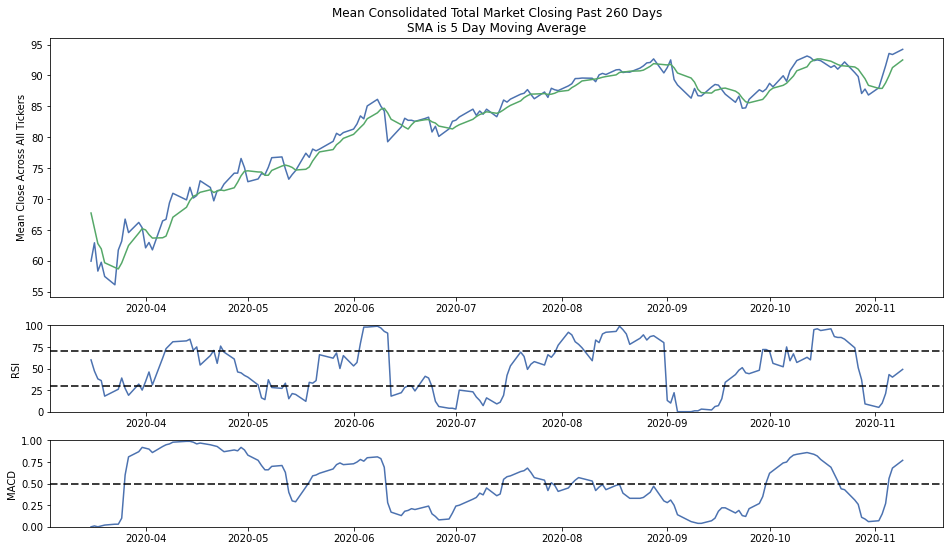

In [75]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [131]:
print("Running Bayesian Parameter Optimization")

## Inititalizing Storage Lists
Return = []; DD = []; nt = []; p = []; oc = [];

## Defining Search Area
pcts = np.arange(0.50,0.95,0.05)
sell = ['open','close']

## Running Brute Force Search
for pct in tqdm(pcts):
    for time in sell:
            Results = Bayesian_Leveraged(
                Combined_Data,
                Combined_Index_Data,
                Index = "^NDX",
                test_window = 90,
                open_close=time,
                pct = pct,
                print_results = False
            )
            Return.append(Results['ret'])
            DD.append(Results['dd'])
            nt.append(Results['nt'])
            p.append(pct)
            oc.append(time)

## Combining Results
Bayes_Results = pd.DataFrame({'+- Bull %':p,'Cumulative Return':Return,'Max Drawdown':DD,'# Trades':nt,'Sell Time':oc}). \
    query('`Cumulative Return` > 1'). \
    assign(Decider = lambda x: x['Cumulative Return'] - x['Max Drawdown']). \
    sort_values('Decider',ascending=False)
Bayes_Results.head(10)    

Running Bayesian Parameter Optimization


,+- Bull %,Cumulative Return,Max Drawdown,# Trades,Sell Time,Decider
8,0.70,5.456,0.049,22,open,5.407
6,0.65,5.333,0.033,29,open,5.300
4,0.60,5.353,0.072,46,open,5.281
0,0.50,5.299,0.095,88,open,5.204
2,0.55,5.292,0.097,65,open,5.195
15,0.85,1.230,0.018,24,close,1.212
11,0.75,1.210,0.018,38,close,1.192
13,0.80,1.155,0.018,27,close,1.137
9,0.70,1.097,0.018,53,close,1.079
17,0.90,1.097,0.040,19,close,1.057


In [134]:
Positive_Prob = np.round(float(Bayes_Results['+- Bull %'].head(1)),2)
Sell_Time = list(Bayes_Results['Sell Time'].head(1))[0]
Optimized_Results = Bayesian_Leveraged(
    Combined_Data,
    Combined_Index_Data,
    Index = "^NDX",
    test_window = 90,
    open_close=Sell_Time,
    pct = Positive_Prob,
    print_results = True
)


Cumulative Return @ Learning Period of 92 : 5.46
Min Index +- Prob: 70.0
Period Evaluated: 88
Max Drawdown: 0.05
Number of Trades: 22
Prob of +ve Index Movement: 8.0
Selling @ Market open


In [128]:
pos_prob = Optimized_Results['pp']/100

## Pulling Relevent Account Information
Account_Equity = Get_Equity(Account)

## Pulling Open Orders
Open_Orders = Get_Open_Orders(Account)

## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings(Account)

## Pulling Current Buying Power
Buying_Power = Get_Buying_Power(Account)

## Pulling Current Prices
TQQQ_Current_Price = api.get_last_trade('TQQQ').price;
T_Buy_Quantity = np.floor(Buying_Power/TQQQ_Current_Price);
SQQQ_Current_Price = api.get_last_trade('SQQQ').price; 
S_Buy_Quantity = np.floor(Buying_Power/SQQQ_Current_Price);

if datetime.now().hour >= 16 & datetime.now().hour < 18:
## Checking Probability Conditions
    if pos_prob > Positive_Prob:
        if 'SQQQ' in list(Current_Holdings.columns):
            print("Closing SQQQ Position")
            Limit_Order(
                s = 'SQQQ',
                Quantity = Current_Holdings.loc['quantity','SQQQ'],
                Limit = SQQQ_Current_Price,
                side = 'sell',
                Account = Account
            )
            sleep(15)
        if 'TQQQ' in list(Current_Holdings.columns):
            print("Maintaining Position in TQQQ")
        else:
            print("Opening TQQQ Position") 
            Limit_Order(
                s = 'TQQQ',
                Quantity = T_Buy_Quantity,
                Limit = TQQQ_Current_Price,
                side = 'buy',
                Account = Account
            )
    elif 1 - pos_prob > Positive_Prob:
        if 'TQQQ' in list(Current_Holdings.columns):
            print("Closing TQQQ Position Moving to Short")
            Limit_Order(
                s = 'TQQQ',
                Quantity = Current_Holdings.loc['quantity','TQQQ'],
                Limit = TQQQ_Current_Price,
                side = 'sell',
                Account = Account
            )
            sleep(15)
        if 'SQQQ' in list(Current_Holdings.columns):
            print("Maintaining Position in SQQQ")
        else:
            print("Opening SQQQ Position")    
            Limit_Order(
                s = 'SQQQ',
                Quantity = S_Buy_Quantity,
                Limit = SQQQ_Current_Price,
                side = 'buy',
                Account = Account
            )
    else:
        print("+- Probability Not Met, No Investments Today") 
        ## Closing Any Open Investments
        if 'TQQQ' in list(Current_Holdings.columns):
            print("Closing TQQQ Position")
            Limit_Order(
                s = 'TQQQ',
                Quantity = Current_Holdings.loc['quantity','TQQQ'],
                Limit = TQQQ_Current_Price,
                side = 'sell',
                Account = Account
            )
        if 'SQQQ' in list(Current_Holdings.columns):
                print("Closing SQQQ Position")
                Limit_Order(
                    s = 'SQQQ',
                    Quantity = Current_Holdings.loc['quantity','SQQQ'],
                    Limit = SQQQ_Current_Price,
                    side = 'sell',
                    Account = Account
                )
elif datetime.now().hour >= 9 & datetime.now().hour < 16:
    print("Closing Any Current Holdings") 
    ## Closing Any Open Investments
    if 'TQQQ' in list(Current_Holdings.columns):
        print("Closing TQQQ Position")
        Limit_Order(
            s = 'TQQQ',
            Quantity = Current_Holdings.loc['quantity','TQQQ'],
            Limit = TQQQ_Current_Price,
            side = 'sell',
            Account = Account
        )
    if 'SQQQ' in list(Current_Holdings.columns):
            print("Closing SQQQ Position")
            Limit_Order(
                s = 'SQQQ',
                Quantity = Current_Holdings.loc['quantity','SQQQ'],
                Limit = SQQQ_Current_Price,
                side = 'sell',
                Account = Account
            )
else:
    print("Outside of Tradable Market Hours")

Opening SQQQ Position For The Next Trading Day

Order ID: f168cf5e-6f6c-4634-be41-757b5539388b placed
